In [1]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#parameters

M = 64 # lattices

dim = 1
dirs = 3

w0 = 2/3
w1 = 1/6 
w2 = 1/6 
e0 = 0
e1 = 1   ##right
e2 = -1  ##left
cs = 1/np.sqrt(3)   ##speed of sound
u = 0.2  ##advection 


x = w1*(1+e1*u/cs**2)
y = w2*(1+e2*u/cs**2)
z = w0*(1+e0*u/cs**2)

lambda1 = np.arccos(x)
lambda2 = np.arccos(y)
lambda0 = np.arccos(z)
lambdas = (lambda0, lambda1, lambda2)

x,y,z

(0.2666666666666666, 0.06666666666666668, 0.6666666666666666)

In [3]:
def createLambda(oper, isC1 = True):
    
    if oper == 0:
        s = '10'
    elif oper == 1:
        s = '00'
    else:
        s = '01'
    
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1
    
    qc = QuantumCircuit(dirs)
    
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    
    gate = tmp.to_gate(label = "Lambda"+str(oper)).control(1, ctrl_state=int(s[1])).control(1,ctrl_state = int(s[0]))
    
    qc.append(gate,list(range(dirs))[::-1])
    return qc

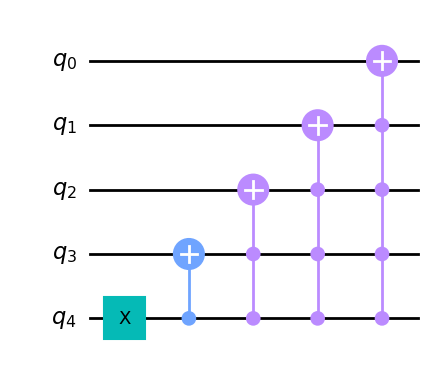

In [4]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def prop(n):
    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)#.control(0, ctrl_state = 1)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)#.control(0, ctrl_state = 1)
    
    cbits = [n]
    cbits.extend([i for i in range(n-1,-1,-1)])  
    
    qc = QuantumCircuit(n+1)
    qc.append(R,cbits)
    qc.append(L,cbits)
    return qc
lshift(5).draw()

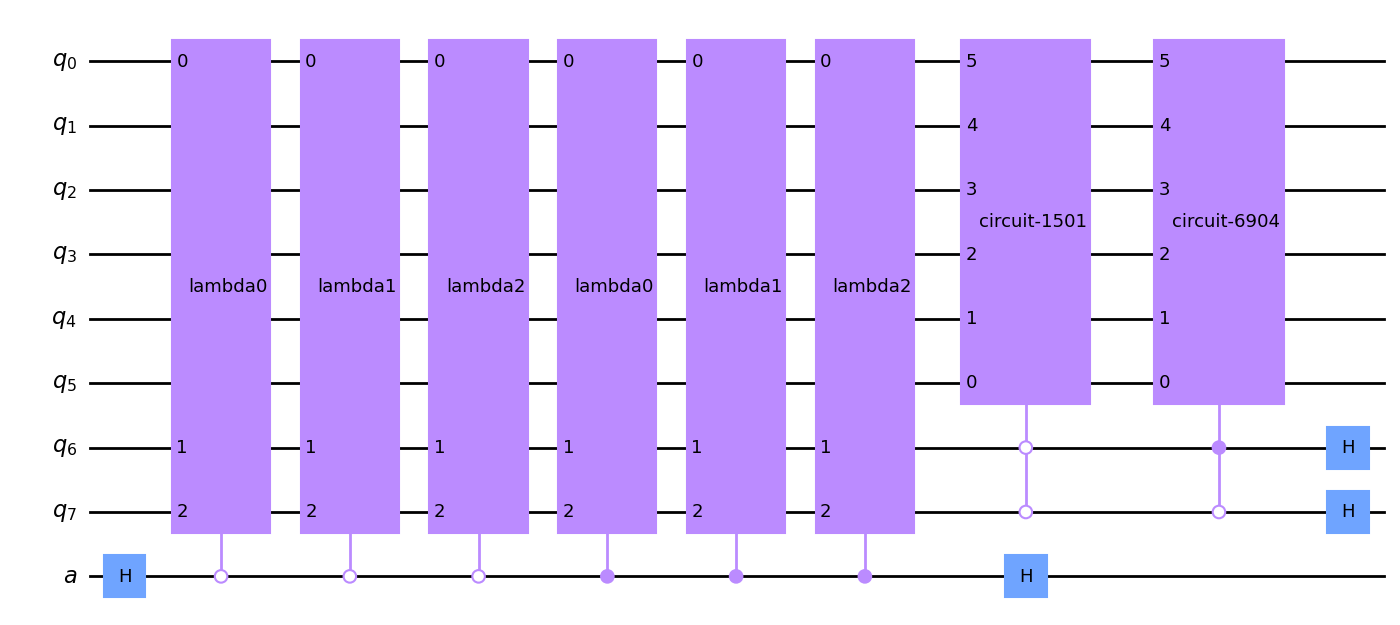

In [5]:
q = QuantumRegister(np.ceil(np.log2(dirs))+np.log2(M),'q')
a = AncillaRegister(1,'a')

setup = QuantumCircuit(q)
setup.add_register(a)

setup.h(a)
setup.append(createLambda(0,True).to_gate(label = 'lambda0').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(1,True).to_gate(label = 'lambda1').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(2,True).to_gate(label = 'lambda2').control(1,ctrl_state = 0),[a,0,6,7])
setup.append(createLambda(0,False).to_gate(label = 'lambda0').control(1,ctrl_state = 1),[a,0,6,7])
setup.append(createLambda(1,False).to_gate(label = 'lambda1').control(1,ctrl_state = 1),[a,0,6,7])
setup.append(createLambda(2,False).to_gate(label = 'lambda2').control(1,ctrl_state = 1),[a,0,6,7])
setup.h(a)

# setup.barrier()
setup.append(rshift(6).to_gate(label = "R").control(1, ctrl_state = 0).control(1,ctrl_state=0),[6,7,5,4,3,2,1,0])
setup.append(lshift(6).to_gate(label = "L").control(1, ctrl_state = 0).control(1,ctrl_state=1),[6,7,5,4,3,2,1,0])
# setup.barrier()

# setup.swap(a,6)
# setup.h(a)
# setup.swap(a,7)
# setup.h(a)
setup.h(6)
setup.h(7)

setup.draw()

In [6]:
#### initialState
initState = np.ones(M)/10  #0.1 everywhere
initState[12] = 0.2
nrm = np.linalg.norm(initState)
initState = np.concatenate((initState,initState,initState,[0 for i in range(M)]))


SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
initSV = SV
array_to_latex(SV,max_size = 256)

<IPython.core.display.Latex object>

In [7]:
def timestep(sv):
    return sv.evolve(setup)

def graph(sv, color = "red"):
    plt.plot(list(range(0,M,1)), np.array(sv)[:M:1],color)
    plt.plot(list(range(1*M,2*M,1)), np.array(sv)[1*M:2*M:1],color)
    plt.plot(list(range(2*M,3*M,1)), np.array(sv)[2*M:3*M:1],color)
    plt.plot(list(range(3*M,4*M,1)), np.array(sv)[3*M:4*M:1],color)
    plt.plot(list(range(4*M,5*M,1)), np.array(sv)[4*M:5*M:1],color)
    plt.plot(list(range(5*M,6*M,1)), np.array(sv)[5*M:6*M:1],color)
    plt.plot(list(range(6*M,7*M,1)), np.array(sv)[6*M:7*M:1],color)
    plt.plot(list(range(7*M,8*M,1)), np.array(sv)[7*M:8*M:1],color)

def hres(sv):
    plt.plot(list(range(0,M,1)), nrm* np.array(sv)[:M]/np.linalg.norm(np.array(sv)[:M]))

def reinit(sv):
    tmp = np.array(sv)[:M]
    tmp = np.concatenate((tmp,tmp,tmp,[0 for i in range(M)]))
    return Statevector(tmp/np.linalg.norm(tmp)).expand([1,0])


[0.10069856 0.10069856 0.10069857 0.1006986  0.1006987  0.10069903
 0.10070005 0.10070295 0.10071059 0.10072934 0.10077196 0.10086171
 0.10103655 0.10135117 0.10187303 0.10266878 0.10377988 0.10519217
 0.10681075 0.10845503 0.10988465 0.11085492 0.11118506 0.1108132
 0.10981517 0.10837935 0.1067489  0.10515563 0.10376961 0.10267799
 0.10189208 0.10137176 0.10105373 0.1008738  0.10077939 0.10073341
 0.10071259 0.10070383 0.10070041 0.10069916 0.10069874 0.10069861
 0.10069857 0.10069856 0.10069856 0.10069856 0.10069856 0.10069856
 0.10069856 0.10069856 0.10069856 0.10069856 0.10069856 0.10069856
 0.10069856 0.10069856 0.10069856 0.10069856 0.10069856 0.10069856
 0.10069856 0.10069856 0.10069856 0.10069856]


/Users/sriharshakocherla/miniforge3/envs/quantum/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


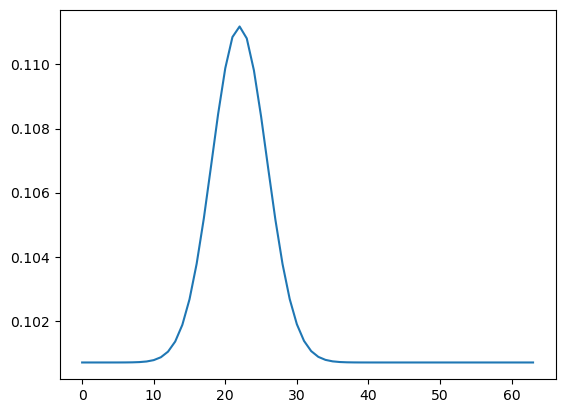

In [8]:
# hres(initSV)
for i in range(1,51):
    SV = timestep(SV)
#     if i%20==0 and i!=80:
    if i==50:
        print(np.real(nrm* np.array(SV)[:M]/np.linalg.norm(np.array(SV)[:M])))
        hres(SV)
    np.savetxt('d1q3/'+str(i+1)+'.csv', np.real(nrm* np.array(SV)[:M]/np.linalg.norm(np.array(SV)[:M])), delimiter=',')
    SV = reinit(SV)

In [9]:
d1q3_10 = [0.10062931, 0.10062931, 0.10062931, 0.10062931, 0.10062931, 0.10062933,
 0.1006297  ,0.1006343 , 0.1006751  ,0.1009338 , 0.10209171 ,0.10563835,
 0.11265786 ,0.12066548, 0.12402766 ,0.12011662, 0.11235274 ,0.10574312,
 0.10223379 ,0.1009827 , 0.10068123 ,0.10063388, 0.10062949 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931, 0.10062931 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931 ,0.10062931 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931 ,0.10062931 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931 ,0.10062931 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931, 0.10062931 ,0.10062931,
 0.10062931 ,0.10062931 ,0.10062931 ,0.10062931, 0.10062931 ,0.10062931,
 0.10062931 ,0.10062931, 0.10062931 ,0.10062931]
d1q2_10 = [0.10061037, 0.10061037, 0.10062092, 0.10061037, 0.10076862, 0.10061037,
 0.10167854 ,0.10061037 ,0.10488303 ,0.10061037 ,0.11182609 ,0.10061037,
 0.12079866 ,0.10061037 ,0.12584573 ,0.10061037 ,0.12224068 ,0.10061037,
 0.11277742 ,0.10061037 ,0.10466606 ,0.10061037 ,0.10121873 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037 ,0.10061037,
 0.10061037 ,0.10061037 ,0.10061037 ,0.10061037]

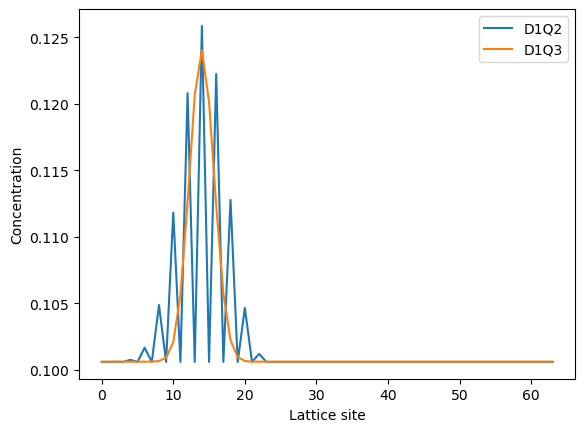

In [10]:
d1q2, = plt.plot(list(range(0,M,1)), d1q2_10, label = 'D1Q2')
d1q3, = plt.plot(list(range(0,M,1)), d1q3_10, label = 'D1Q3')
plt.xlabel("Lattice site")
plt.ylabel("Concentration")
# plt.title('t = 10')
plt.legend(handles = [d1q2, d1q3])
plt.savefig('line_plot.pdf')

In [11]:
d1q2_50=[0.10077818, 0.10069214 ,0.10089218 ,0.10069214 ,0.10112079 ,0.10069214,
 0.1015397  ,0.10069214 ,0.10223986 ,0.10069214 ,0.10330392 ,0.10069214,
 0.10476651 ,0.10069214 ,0.10656863 ,0.10069214 ,0.10852746 ,0.10069214,
 0.11034638 ,0.10069214 ,0.111678   ,0.10069214 ,0.11222729 ,0.10069214,
 0.11185519 ,0.10069214 ,0.11063423 ,0.10069214 ,0.10882658 ,0.10069214,
 0.10679297 ,0.10069214 ,0.10487557 ,0.10069214 ,0.10330678 ,0.10069214,
 0.10217613 ,0.10069214 ,0.10145366 ,0.10069214 ,0.10104361 ,0.10069214,
 0.10083713 ,0.10069214 ,0.10074519 ,0.10069214 ,0.10070919 ,0.10069214,
 0.10069691 ,0.10069214 ,0.1006933  ,0.10069214 ,0.10069246 ,0.10069214,
 0.10069253 ,0.10069214 ,0.10069341 ,0.10069214 ,0.10069627 ,0.10069214,
 0.10070453 ,0.10069214, 0.1007262 , 0.10069214]

d1q3_50 = [0.10069856, 0.10069856, 0.10069857 ,0.1006986 , 0.1006987,  0.10069903,
 0.10070005 ,0.10070295, 0.10071059 ,0.10072934 ,0.10077196 ,0.10086171,
 0.10103655 ,0.10135117 ,0.10187303 ,0.10266878 ,0.10377988 ,0.10519217,
 0.10681075 ,0.10845503 ,0.10988465 ,0.11085492 ,0.11118506 ,0.1108132,
 0.10981517 ,0.10837935 ,0.1067489  ,0.10515563 ,0.10376961 ,0.10267799,
 0.10189208 ,0.10137176 ,0.10105373 ,0.1008738  ,0.10077939 ,0.10073341,
 0.10071259 ,0.10070383 ,0.10070041 ,0.10069916 ,0.10069874 ,0.10069861,
 0.10069857 ,0.10069856 ,0.10069856 ,0.10069856 ,0.10069856 ,0.10069856,
 0.10069856 ,0.10069856 ,0.10069856 ,0.10069856 ,0.10069856 ,0.10069856,
 0.10069856 ,0.10069856 ,0.10069856, 0.10069856 ,0.10069856 ,0.10069856,
 0.10069856 ,0.10069856 ,0.10069856 ,0.10069856]

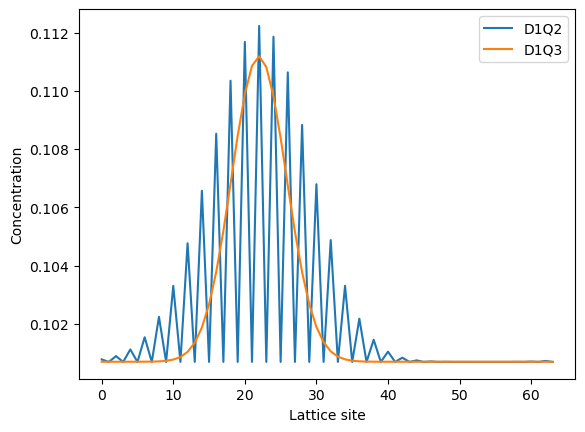

In [12]:
d1q2, = plt.plot(list(range(0,M,1)), d1q2_50, label = 'D1Q2')
d1q3, = plt.plot(list(range(0,M,1)), d1q3_50, label = 'D1Q3')
plt.xlabel("Lattice site")
plt.ylabel("Concentration")
# plt.title('t = 50')
plt.legend(handles = [d1q2, d1q3])
plt.savefig('line_plot50.pdf')